## Metric learning

## Цель задания - познакомиться с алгоритмами metric learning

## Описание задания:

В рамках данного домашнего задания предлагается решить задачу поиска похожего автомобиля в базе данных (автомобиля того же класса). На основе датасета [cars196](https://paperswithcode.com/sota/metric-learning-on-cars196) , ссылка на данные [мета](https://drive.google.com/file/d/1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7/view?usp=sharing) [data](https://drive.google.com/file/d/1l9EnYMC-xGX706SY1kN8RceMmFViASfx/view?usp=sharing).



Процесс выполнения задания следующий:



0. Выбор модели эмбеддера:

    1. Выберите модель кодирующую изображения для выполнения домашнего задания



1. Подготовка обучающего набора данных

    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера).

    2. Добавьте аугментации в датасет 



2. Реализация корректного train-loop и обучение модели:  

    1. Реализуйте train-loop для вашей модели и проведите обучение c Triplet loss

    2. При формировании триплета не просто брать отрицательный класс, а воспользоваться техникой hard negative mining

    3. Обучите модель и воcпользуйте иными loss функциями для задачи metric learning

 

3. Валидация обученных моделей на тестовой выборке, вычисление метрики Recall и Precision

    1. Оцените качество моделей на тестовой части данных и рассчитайте метрики поиска Recall@1, Recall@5, Precision@1, Precision@5. Обратите внимание, что для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта, а должны производить поиск на основе получившихся эмбеддингов

    2. При поиске воспользоваться библиотекой Faiss







In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
from torch.utils.data import DataLoader
import skimage
import torch
import torch.nn as nn
import gc
from tqdm import tqdm
import IPython

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Выбор модели эмбеддинга

В качестве модели выберем предобученную EfficientNet

In [3]:
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

In [4]:
model = efficientnet_b5(weights=EfficientNet_B5_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 148MB/s]  


In [5]:
model.classifier

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=2048, out_features=1000, bias=True)
)

### Подготовка обучающего набора данных

In [6]:
import scipy.io
mat = scipy.io.loadmat('/kaggle/input/hw8-cars196/devkit/devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('/kaggle/input/hw8-cars196/devkit/devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [7]:
PATH = '/kaggle/input/hw8-cars196/archive/cars_train/cars_train'

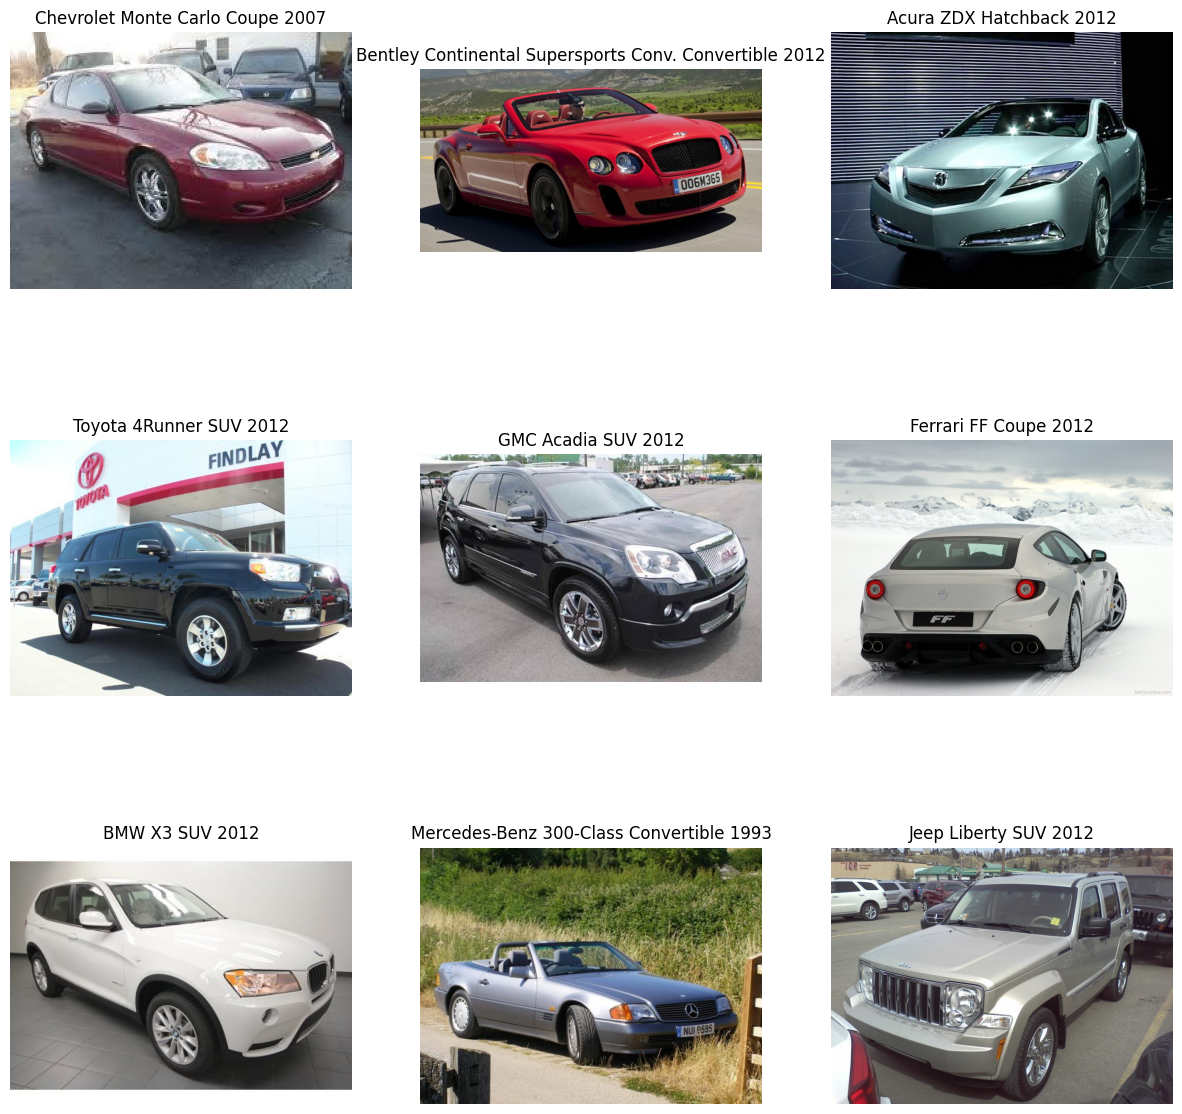

In [8]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

In [9]:
from sklearn.model_selection import train_test_split

val_transforms =  torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])


class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms
        
    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

In [10]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, val_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)

torch.Size([3, 224, 224])


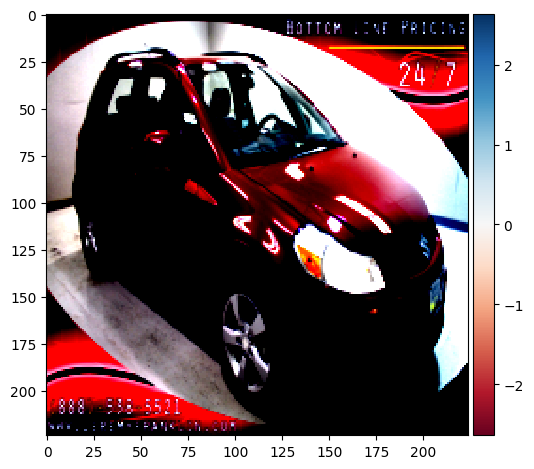

In [11]:
for i in train_dataset:
    print(i['image'].shape)
    skimage.io.imshow(i['image'].permute(1,2,0).numpy())
    
    break

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, collate_fn=None,drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

torch.Size([32, 3, 224, 224])
tensor([186, 159,  20,  85, 163,  15, 167,  93, 161, 123,  74, 179, 127, 192,
        145,  88, 130, 145, 175, 147,  36,  21,  56, 156, 174,  33,  97,  72,
         48, 144,  92,  59])


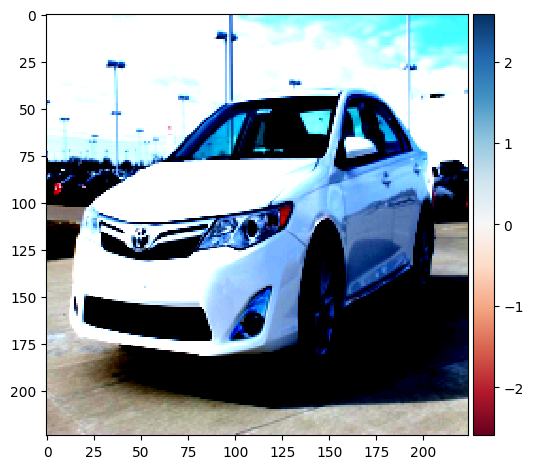

In [13]:
for i in train_loader:
    print(i['image'].shape
         )
    print(i['label'])
    skimage.io.imshow(i['image'][0].permute(1,2,0).numpy())
    break

### Обучение модели

Загрузим библиотеку с triplet loss

In [14]:
!pip install pytorch-metric-learning

from pytorch_metric_learning import losses, miners

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 3.8 MB/s eta 0:00:00


In [15]:
triplet_loss = losses.TripletMarginLoss()

In [18]:
def eval_step(model, loss_fn, images, labels):
    model.eval()
    with torch.no_grad():
        embeddings = model(images)    
        loss = loss_fn(embeddings, labels)

    return loss

In [19]:
def train(model, optimizer, loss_fn, train_dl, val_dl, num_epochs = 20, miner = None):

    loss_train = []
    loss_val = []

    
    for epoch in tqdm(range(num_epochs)):

        IPython.display.clear_output(wait=True)
        curr_loss_tr = []
        curr_loss_val = []
        
        model.train()
        
        for batch in train_dl:
            images, labels = batch['image'].to(device), batch['label'].to(torch.long).to(device)
    
            optimizer.zero_grad()
            
            embeddings = model(images)

            if miner!=None:
                #add miner
                hard_pairs = miner(embeddings,labels)     
                loss = loss_fn(embeddings, labels, hard_pairs)
            else:
                loss = loss_fn(embeddings, labels)

            curr_loss_tr.append(loss.item())
            loss.backward()
            optimizer.step()

            
        
        


        model.eval()
        with torch.no_grad():
            for batch in val_dl:
                images, labels = batch['image'].to(device), batch['label'].to(torch.long).to(device)

                loss = eval_step(model, loss_fn, images, labels)
                curr_loss_val.append(loss.item())

        loss_train.append(curr_loss_tr)
        loss_val.append(curr_loss_val)
        print(f'On {epoch+1} epoch loss_train {curr_loss_tr[epoch]}, loss_val {curr_loss_val[epoch]}')

    return {'model' : model, 'loss_train' :loss_train, 'loss_val' :loss_val}




Проведем обучение модели, при этом пары triplet loss будут майниться с помощью hard negative mining

In [20]:
# размер эмбеддинга задаем заранее
emb_size = 512

# Модель EffecientNet для формирования эмбеддингов
model = efficientnet_b5(weights=EfficientNet_B5_Weights.IMAGENET1K_V1)
#Надо заменить полносвязные слои, чтобы получать эмбеддинг нужного размера
model.classifier = nn.Sequential(
    nn.ReLU(),
    # nn.Dropout(p = 0.5),
    nn.Linear(2048, emb_size, bias=True),
)
model = model.to(device)



In [21]:
torch.cuda.empty_cache() 
gc.collect()

6558

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)
loss_triplet = losses.TripletMarginLoss()
#add hard-negatives miner
miner = miners.TripletMarginMiner(margin=0.2, type_of_triplets="hard")

metrics = train(model,optimizer, loss_fn=loss_triplet, train_dl=train_loader, val_dl = valid_loader,num_epochs=20 , miner = miner)

100%|██████████| 20/20 [31:32<00:00, 94.63s/it]

On 20 epoch loss_train 0.06070902198553085, loss_val 0.0181571077555418


Сохраним веса модели

In [23]:
weights = metrics['model'].state_dict()
torch.save(weights, 'weigths_Triplet_EfficientNet_b5.pt')

model.load_state_dict(weights)

<All keys matched successfully>

In [45]:
model.load_state_dict(torch.load('/kaggle/input/efficientnet-b5-metric-learning/pytorch/default/1/weigths_EfficientNet_b5.pt'))

/tmp/ipykernel_30/1973421319.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/efficientnet-b5-metric-learning/pytorch/defa

<All keys matched successfully>

Теперь обучим модель с другим loss - Contrastive Loss

In [23]:

emb_size = 512

model_contr = efficientnet_b5(weights=EfficientNet_B5_Weights.IMAGENET1K_V1)
#Надо заменить полносвязные слои, чтобы получать эмбеддинг нужного размера
model_contr.classifier = nn.Sequential(
    nn.ReLU(),
    # nn.Dropout(p = 0.5),
    nn.Linear(2048, emb_size, bias=True),
)
model_contr = model_contr.to(device)



In [26]:
optimizer = torch.optim.Adam(model_contr.parameters(), lr = 3e-4)
loss_contr = losses.ContrastiveLoss(pos_margin=0, neg_margin=1)

metrics = train(model_contr,optimizer, loss_fn=loss_contr, train_dl=train_loader, val_dl = valid_loader, num_epochs=20)

100%|██████████| 20/20 [31:24<00:00, 94.22s/it]

On 20 epoch loss_train 1.0875344276428223, loss_val 0.8996700048446655


In [27]:
weights = metrics['model'].state_dict()
torch.save(weights, 'weigths_Contrastive_EfficientNet_b5.pt')

model_contr.load_state_dict(weights)

<All keys matched successfully>

In [44]:
model_contr.load_state_dict(torch.load('/kaggle/input/weigths_efficientnet_b5_contranstive_loss/pytorch/default/1/weigths_Contrastive_EfficientNet_b5.pt'))

/tmp/ipykernel_30/2490452614.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_contr.load_state_dict(torch.load('/kaggle/input/weigths_efficientnet_b5_contranstive_l

<All keys matched successfully>

### Вычисление метрик

Для поиска схожих эмбеддингов воспользуемся библиотекой Faiss

In [25]:
!pip install faiss-cpu --no-cache faiss-gpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 234.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 216.9 MB/s eta 0:00:00a 0:00:01


In [26]:
import faiss

In [27]:
model = model.to(device)

In [28]:
def get_embeds(model, loader):
    embeddings = np.empty((1,512))
    labels = np.empty((1))
    for batch in tqdm(loader):
        imgs = batch['image']
        label = batch['label']
        with torch.no_grad():
            preds = model(imgs.to(device))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label.numpy()])
    return embeddings[1:].astype(np.float32), labels[1:]

Для каждого изображения создаем эмбеддинг с разметкой

In [29]:
train_emb, train_labels = get_embeds(model, train_loader)
val_emb, val_labels = get_embeds(model, valid_loader)

100%|██████████| 51/51 [00:16<00:00,  3.15it/s]


In [30]:
train_emb, train_labels.astype(int)

(array([[ 2.9914918 ,  2.4122603 ,  4.587456  , ...,  0.575829  ,
         -0.98005044, -3.7456827 ],
        [ 3.5958996 ,  2.8309548 ,  5.688484  , ...,  1.2059752 ,
         -1.0580448 , -5.0234876 ],
        [ 2.553641  ,  2.00381   ,  4.2292104 , ...,  0.46146393,
         -1.006223  , -3.4289098 ],
        ...,
        [ 2.5006073 ,  1.9153755 ,  4.2972765 , ...,  0.55145764,
         -0.6903559 , -3.919104  ],
        [ 1.8027434 ,  1.6324065 ,  3.3379593 , ...,  0.49454376,
         -0.36548752, -2.9148002 ],
        [ 2.642318  ,  2.2780309 ,  4.7954745 , ...,  0.4243446 ,
         -0.66556615, -4.191298  ]], dtype=float32),
 array([109, 164, 187, ..., 187, 178, 112]))

In [31]:
index = faiss.IndexFlatL2(emb_size)   # build the index
print(index.is_trained)
index.add(train_emb)                  # add vectors to the index
print(f"Всего векторов в train выборке: {index.ntotal}")

k = 4                          # we want to see 4 nearest neighbors
D_train, I_train = index.search(train_emb[:5], k) # sanity check
print("Индексы ближайших соседей:",I_train)
print("Расстояния до этих соседей:",D_train)
print("___"*20)
D, I = index.search(val_emb, k)     # actual search
print("Индексы ближайших соседей:",I[:5])    # neighbors of the 5 first queries
print("Расстояния до этих соседей:",D[:5])

True
Всего векторов в train выборке: 6496
Индексы ближайших соседей: [[   0 3646 5049 4372]
 [   1 5302 5541 2482]
 [   2 5334 2361   67]
 [   3 3175 1764 5404]
 [   4 6402 2468 2733]]
Расстояния до этих соседей: [[ 0.        10.8030205 11.860485  11.99428  ]
 [ 0.        17.973328  20.654875  20.759958 ]
 [ 0.         6.739791   8.650381   8.722767 ]
 [ 0.        11.092968  16.794209  18.806528 ]
 [ 0.        10.14305   13.378123  13.385599 ]]
____________________________________________________________
Индексы ближайших соседей: [[2952  753  361  743]
 [3106 2622  646 3956]
 [5950 4841 1965 2406]
 [2855  802 1062 2614]
 [2846  476 5729 1483]]
Расстояния до этих соседей: [[ 6.6049805  7.376953  11.170898  12.046875 ]
 [10.899414  11.301758  11.662109  12.324707 ]
 [ 6.602539   8.474121   9.07959   10.526367 ]
 [ 6.2753906 10.071289  11.140625  11.723633 ]
 [10.003662  10.009033  10.446289  11.322998 ]]


Вычислим метрики и посмотрим на результаты для триплет модели

In [32]:
def precision_at_k(val_emb,train_labels, val_labels,  k):
    
    #нашли индексы ближайших соседей для каждого эмбеддинга
    Distances, Indexes = index.search(val_emb, k)
    #лэйблы ближайших соседей из train выборки
    nn_labels = train_labels[Indexes]

    precision_by_row = []
    for row in range(nn_labels.shape[0]):
        precision = np.sum(nn_labels[row,:] == val_labels[row]) / k
        precision_by_row.append( precision )
        

    
    return sum(precision_by_row) / val_labels.shape[0]
    
def recall_at_k(val_emb,train_labels, val_labels,  k):
    #нашли индексы ближайших соседей для каждого эмбеддинга
    Distances, Indexes = index.search(val_emb, k)
    #лэйблы ближайших соседей из train выборки
    nn_labels = train_labels[Indexes]

    
    recall_by_row = []
    for row in range(nn_labels.shape[0]):
        recall = np.sum(nn_labels[row,:] == val_labels[row]) / np.sum(train_labels == val_labels[row])
        recall_by_row.append( recall )
    
    
    return sum(recall_by_row) / val_labels.shape[0]



In [33]:
print(f'Precision @ 1 : {precision_at_k(val_emb, train_labels, val_labels,1)}')
print(f'Recall @ 1 : {recall_at_k(val_emb, train_labels, val_labels,1)}')
print()
print(f'Precision @ 5 : {precision_at_k(val_emb, train_labels, val_labels,5)}')
print(f'Recall @ 5 : {recall_at_k(val_emb, train_labels, val_labels,5)}')

Precision @ 1 : 0.18845917740945364
Recall @ 1 : 0.005828261625161859

Precision @ 5 : 0.13038674033149097
Recall @ 5 : 0.020027039578342253


Теперь замерим метрики у модели с Contrastive loss

In [34]:
train_emb, train_labels = get_embeds(model_contr, train_loader)
val_emb, val_labels = get_embeds(model_contr, valid_loader)

100%|██████████| 51/51 [00:09<00:00,  5.35it/s]


In [35]:
index = faiss.IndexFlatL2(emb_size)   # build the index
print(index.is_trained)
index.add(train_emb)                  # add vectors to the index


True


In [36]:
print(f'Precision @ 1 : {precision_at_k(val_emb, train_labels, val_labels,1)}')
print(f'Recall @ 1 : {recall_at_k(val_emb, train_labels, val_labels,1)}')
print()
print(f'Precision @ 5 : {precision_at_k(val_emb, train_labels, val_labels,5)}')
print(f'Recall @ 5 : {recall_at_k(val_emb, train_labels, val_labels,5)}')

Precision @ 1 : 0.10865561694290976
Recall @ 1 : 0.0032726072776601005

Precision @ 5 : 0.08827501534683875
Recall @ 5 : 0.013377200627920683


### GradCam

In [37]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39587 sha256=b754827819c5e3451c58de81b5bcf70721ecdd760236377a9acb63f1da878336
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [46]:
import requests
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

Последний Conv слой модели, в который мы добавим GradCam

In [47]:
model.features[7][2]

MBConv(
  (block): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(512, 3072, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(3072, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(3072, 3072, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3072, bias=False)
      (1): BatchNorm2d(3072, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (2): SqueezeExcitation(
      (avgpool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Conv2d(3072, 128, kernel_size=(1, 1), stride=(1, 1))
      (fc2): Conv2d(128, 3072, kernel_size=(1, 1), stride=(1, 1))
      (activation): SiLU(inplace=True)
      (scale_activation): Sigmoid()
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(3072, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=0.001, momentum=0.01, affine=True, 

Предварительная обработка картинки

In [48]:
IMG_PATH = '/kaggle/input/hw8-cars196/archive/cars_train/cars_train/00012.jpg'


transform_to_show = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(), 
                        torchvision.transforms.Resize(
                            size=(224, 224)
                        ),
                        torchvision.transforms.ToTensor()
                        ])
def get_image_from_path(path):
    """A function that gets a path to an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    orig_im = np.array(Image.open(path).convert('RGB'))
    rgb_im = np.array(transform_to_show(orig_im).permute(1,2,0))
    transformed_im = val_transforms(orig_im).unsqueeze(0).to(device)
    orig_im = cv2.resize(orig_im, (512, 512))

    return orig_im, rgb_im, transformed_im

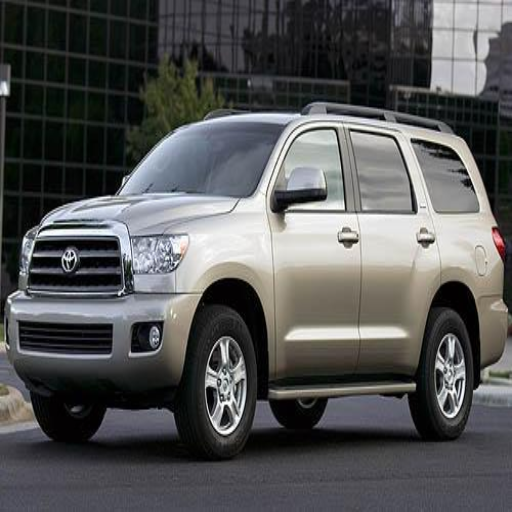

In [51]:

car_img, car_img_float, car_tensor = get_image_from_path(IMG_PATH)

car_concept_features = model(car_tensor.to(device))[0, :]

Image.fromarray(car_img)

Сначала посмотрим на модель с Triplet loss

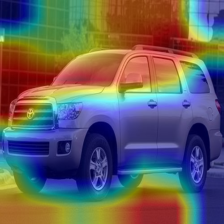

In [55]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)


#необходимый слой
target_layers = [model.features[7][2]]

#Как мы будем определять, что влияет на предсказание
car_targets = [SimilarityToConceptTarget(car_concept_features)]

#сама модель для отрисовка heatmaps
with GradCAM(model=model,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=car_tensor,
                        targets=car_targets)[0, :]

car_cam_image = show_cam_on_image(car_img_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

Теперь посмотрим на GradCam модели, обученной на Contrastive loss

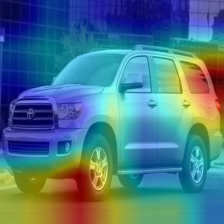

In [56]:
#необходимый слой
target_layers = [model_contr.features[7][2]]


#Как мы будем определять, что влияет на предсказание
car_targets = [SimilarityToConceptTarget(car_concept_features)]

#сама модель для отрисовка heatmaps
with GradCAM(model=model_contr,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=car_tensor,
                        targets=car_targets)[0, :]
    
car_cam_image = show_cam_on_image(car_img_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

Видно, что модель с Triplet loss смотрим больше на кузов машины, на верхнюю часть. Contrastive же определяет по каким-то другим, не совсем понятным признакам, из-за чего у данной модели ниже Precision и Recall

### Выводы

Таким образом, удалось обучить 2 модели metric learning - с Triplet и Contrastive лоссами. Очевидно, что триплет модель будет работать лучше, так как оценивает на 3 объектах, а не на 2, как Contrastive. Улучшить модели можно, поменяв loss на более прокачанный (ArcFace, CosFace), увеличив размер батча(больший не влезал на видеокарту) или увеличив датасет. Также с помощью библиотеки faiss замерил метрики precision@k и recall@k, и с помощью GradCam наглядно увидел, с помощью каких деталей на изображении модель делает предсказания